In [1]:
from collections import defaultdict, Counter
import os
import json
import random 
import numpy as np
from collections import defaultdict, Counter
from PIL import Image
from argparse import Namespace 
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence # 压紧填充序列
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.models import ResNet101_Weights
from nltk.translate.bleu_score import corpus_bleu
from typing import Optional
from timm.models.layers import DropPath
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
import os
from nltk.translate.bleu_score import corpus_bleu
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from transformers import ViTModel, BertModel, BertConfig
from torch.nn import TransformerDecoder, TransformerDecoderLayer
import math

dataset='deepfashion-multimodal'
img_path = '/home/u2021213687/ImageCaptioning/ARCTIC/deepfashion-multimodal/images'
train_json_path= '/home/u2021213687/ImageCaptioning/ARCTIC/deepfashion-multimodal/train_captions.json'
test_json_path= '/home/u2021213687/ImageCaptioning/ARCTIC/deepfashion-multimodal/test_captions.json'
vocab_path = '/home/u2021213687/ImageCaptioning/ARCTIC/deepfashion-multimodal/vocab.json'
def create_dataset(dataset='deepfashion-multimodal',
                   captions_per_image=5, 
                   min_word_count=5, 
                   max_len=30):

    #karpathy_json_path= f'../data/{dataset}/dataset_flickr8k.json'
    #train_json_path='/home/u2021213687/ImageCaptioning/ARCTIC/deepfashion-multimodal/train_captions.json '  #f'data/{dataset}/train_captions.json'
    #test_json_path= '/home/u2021213687/ImageCaptioning/ARCTIC/deepfashion-multimodal/test_captions.json' #f'data/{dataset}/test_captions.json'
    #image_folder='./deepfashion-multimodal/images'   #f'data/{dataset}/images' 
    output_folder=f'data/{dataset}'
    data_all={}
    with open(train_json_path, 'r') as j:
        data_train=json.load(j)
        data_all.update(data_train)
    with open(test_json_path, 'r') as j:
        data_test=json.load(j)
        data_all.update(data_test)
    #data 是现在的 data_all

    
    image_paths = defaultdict(list) # 图片路径
    image_captions = defaultdict(list) # 图片对应的文本描述
    vocab = Counter() # 词频统计
    print(f"data_all.keys()_len:{len(data_all.keys())}")
    max_len=0
    for img_path in data_all.keys(): #遍历所有图片统计词频
        c=data_all[img_path] #一个长字符串 -- 还没分词
        c.replace(",","")
        c.replace(".","")
        c_ls=c.split() #分句
        if len(c_ls)>max_len:
            max_len=len(c_ls)
        vocab.update(c_ls)
    print(vocab)
    print(f"最大的描述长度|max_len:{max_len}")
    # 创建词典，增加占位标识符<pad>、未登录词标识符<unk>、句子首尾标识符<start>和<end>
    words = [w for w in vocab.keys() if vocab[w] > min_word_count]
    vocab = {k: v + 1 for v, k in enumerate(words)} #从1开始标号
    vocab['<pad>'] = 0 #填充
    vocab['<unk>'] = len(vocab) #未登录词
    vocab['<start>'] = len(vocab) #句子首部
    vocab['<end>'] = len(vocab) #句子尾部
    print(vocab)
    # 存储词典
    with open(os.path.join(output_folder, 'vocab.json'), 'w') as fw:
        json.dump(vocab, fw)
def cap_to_wvec(vocab,cap):#将文本描述转换成向量
    cap.replace(",","")
    cap.replace(".","")
    cap=cap.split()
    res=[]
    for word in cap:
        if word in vocab.keys():
            res.append(vocab[word])
        else: #不在字典的词
            res.append(vocab['<unk>'])
    return res

#with open(test_json_path, 'r') as f:
    #data = json.load(f)
class ImageTextDataset(Dataset):
    def __init__(self, dataset_path, vocab_path, split, captions_per_image=1, max_len=93, transform=None):

        self.split = split
        assert self.split in {'train', 'test'}
        self.cpi = captions_per_image
        self.max_len = max_len

        # 载入数据集
        with open(dataset_path, 'r') as f:
            self.data = json.load(f) #key是图片名字 value是描述
            self.data_img=list(self.data.keys())
        # 载入词典
        with open(vocab_path, 'r') as f:
            self.vocab = json.load(f)

        # PyTorch图像预处理流程
        self.transform = transform

        # Total number of datapoints
        self.dataset_size = len(self.data_img)

    def __getitem__(self, i):
        # 第i个文本描述对应第(i // captions_per_image)张图片
        img = Image.open(img_path+"/"+self.data_img[i]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        c_vec=cap_to_wvec(self.vocab,self.data[self.data_img[i]])
        #加入起始和结束标志
        c_vec = [self.vocab['<start>']] + c_vec + [self.vocab['<end>']]
        caplen = len(c_vec)
        caption = torch.LongTensor(c_vec+ [self.vocab['<pad>']] * (self.max_len + 2 - caplen))
        
        return img, caption, caplen
        
    def __len__(self):
        return self.dataset_size
    
def mktrainval(data_dir, vocab_path, batch_size, workers=4):
    train_tx = transforms.Compose([
        transforms.Resize((224, 224)), # 重置图像分辨率
        transforms.RandomCrop(224), # 随机裁剪
        transforms.ToTensor(), # 转换成Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 标准化--三个参数为三个通道的均值和标准差
    ])
    val_tx = transforms.Compose([
        transforms.Resize((224, 224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    train_set = ImageTextDataset(os.path.join(data_dir, 'train_captions.json'), vocab_path, 'train',  transform=train_tx)
    test_set = ImageTextDataset(os.path.join(data_dir, 'test_captions.json'), vocab_path, 'test', transform=val_tx)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)

    return train_loader, test_loader 

def window_reverse(windows, window_size: int, H: int, W:int):
    # 将窗口还原成一个feature map. H,W 代表分割之前的H,W
    # windows: [B * window_num , MH, MW, C]
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    # view: [B * window_num , MH, MW, C] -> [B, H//M, W//M, M, M, C]
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    # permute: [B, H//M, W//M, M, M, C] -> [B, H//M, M, W//M, M, C]
    # view: [B, H//M, M, W//M, M, C] -> [B, H, W, C]
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)

    return x
# 指定window大小，重新划分window
def window_partition(x, window_size: int):
    # 将feature map(image mask) 按照 window_size的大小 划分成一个个没有重叠的window
    B, H, W, C = x.shape
    # [B, H//M, W//M, M, C] M: window_size
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    # permute: [B, H//M, M, W//M, M, C] -> [B, H//M, W//M, M, M, C]
    # contiguous(): 变为内存连续的数据
    # view： [B, H//M, W//M, M, M, C] -> [B * window_num, MH, MW, C] 第一个M为窗口H， 第二个M为窗口W
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)

    return windows

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, act=nn.GELU, drop=0.):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act()
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)

        return x

# 
class WindowAttention(nn.Module):
    # W-MSA SW-MSA
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super(WindowAttention, self).__init__()

        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5 # 根号d

        self.relative_positive_bias_table = nn.Parameter(
        	# 长度为[(2*Mh-1) * (2*Mw-1), num_heads]
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads) 
        )

        # 生成relative_position_index
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w],indexing='ij')) # [2, Mh, Mw]
        coords_flatten = torch.flatten(coords, 1) # [2, Mh*Mw] 绝对位置索引
        # [2, Mh*Mw, 1] - [2, 1, Mh*Mw]
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous() # [Mh, Mw, 2]
        # 二元索引->一元索引
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1) # [Mh*Mw, Mh*Mw]
        # 放到模型缓存中
        self.register_buffer('relative_position_index', relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        nn.init.trunc_normal_(self.relative_positive_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask: Optional[torch.Tensor] = None):
        # [batch_size * num_windows, Mh*Mw, total_embed_dim]
        B_, N, C = x.shape
        # qkv: -> [batch_size * num_windows, Mh*Mw, 3 * total_embed_dim]
        # reshape: -> [batch_size * num_windows, Mh*Mw, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size * num_windows, num_heads, Mh*Mw, embed_dim_per_head]
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # [batch_size * num_windows, num_heads, Mh*Mw, embed_dim_per_head]
        q, k, v = qkv.unbind(0)

        q = q * self.scale
        # transpose: -> [batch_size * num_windows, num_heads,embed_dim_per_head, Mh*Mw]
        # @: multiply: -> [batch_size * num_windows, num_heads, Mh*Mw, Mh*Mw]
        attn = (q @ k.transpose(-2, -1))
        # self.relative_positive_bias_table.view: -> [Mh*Mw*Mh*Mw, num_head] -> [Mh*Mw, Mh*Mw, num_head]
        relative_position_bias = self.relative_positive_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous() # [num_head, Mh*Mw, Mh*Mw]
        # [batch_size * num_windows, num_heads, Mh * Mw, Mh * Mw]
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            # mask: [num_windows, Mh*Mw, Mh*Mw]
            num_window = mask.shape[0]
            # view: [batch_size, num_windows, num_heads, Mh * Mw, Mh * Mw]
            # mask: [1, num_windows, 1, Mh*Mw, Mh*Mw]
            attn = attn.view(B_ // num_window, num_window, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            # [batch_size*num_windows, num_heads, Mh * Mw, Mh * Mw]
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)
        # @: [batch_size*num_windows, num_heads, Mh * Mw, embed_dim_per_head]
        # transpose: [batch_size*num_windows, Mh * Mw, num_heads, embed_dim_per_head]
        # reshape: [num_windows, Mh * Mw, num_heads*embed_dim_per_head]
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size=7, shift_size=0., mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super(SwinTransformerBlock, self).__init__()

        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = norm_layer(dim)
        self.attn = self._create_attention_module(dim, num_heads, window_size, qkv_bias, attn_drop, drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act=act_layer, drop=drop)

    def _create_attention_module(self, dim, num_heads, window_size, qkv_bias, attn_drop, drop):
        return WindowAttention(
            dim=dim, window_size=(window_size, window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop
        )

    def forward(self, x, attn_mask):
        x, Hp, Wp = self._process_input(x)
        shifted_x = self._shift_and_pad(x)
        x_windows = self._prepare_windows(shifted_x)
        attn_windows = self.attn(x_windows, mask=attn_mask)
        shifted_x = self._reverse_windows(attn_windows, Hp, Wp)
        x = self._restore_data(shifted_x, x.shape, Hp, Wp)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def _process_input(self, x):
        H, W = self.H, self.W  # feature map
        B, L, C = x.shape
        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)
        return x, H, W

    def _shift_and_pad(self, x):
        if self.shift_size > 0.:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x
        return shifted_x

    def _prepare_windows(self, x):
        x_windows = window_partition(x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, x.shape[-1])
        return x_windows

    def _reverse_windows(self, attn_windows, Hp, Wp):
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, attn_windows.shape[-1])
        shifted_x = window_reverse(attn_windows, self.window_size, Hp, Wp)
        return shifted_x

    def _restore_data(self, shifted_x, original_shape, Hp, Wp):
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x_r = (self.window_size - original_shape[2] % self.window_size) % self.window_size
        x_d = (self.window_size - original_shape[1] % self.window_size) % self.window_size
        if x_r > 0 or x_d > 0:
            x = x[:, :original_shape[1], :original_shape[2], :].contiguous()
        x = x.view(original_shape[0], original_shape[1] * original_shape[2], original_shape[3])
        return x


class BasicLayer(nn.Module):
    def __init__(self, dim, depth, num_heads, window_size, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0., norm_layer=nn.LayerNorm, downsample=None):
        super(BasicLayer, self).__init__()

        self.dim = dim
        self.depth = depth
        self.window_size = window_size
        self.shift_size = window_size // 2 

        self.blocks = self._create_blocks(dim, num_heads, window_size, mlp_ratio, qkv_bias, drop, attn_drop, drop_path, norm_layer, depth)
        self.downsample = downsample(dim=dim, norm_layer=norm_layer) if downsample is not None else None

    def _create_blocks(self, dim, num_heads, window_size, mlp_ratio, qkv_bias, drop, attn_drop, drop_path, norm_layer, depth):
        return nn.ModuleList([
            self._create_block(dim, num_heads, window_size, mlp_ratio, qkv_bias, drop, attn_drop, drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer, i) for i in range(depth)
        ])

    def _create_block(self, dim, num_heads, window_size, mlp_ratio, qkv_bias, drop, attn_drop, drop_path, norm_layer, index):
        shift_size = 0 if (index % 2 == 0) else self.shift_size
        return SwinTransformerBlock(
            dim=dim, num_heads=num_heads, window_size=window_size, shift_size=shift_size,
            mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, drop=drop, attn_drop=attn_drop, drop_path=drop_path,
            norm_layer=norm_layer
        )

    def create_mask(self, x, H, W):
        H_padding = int(np.ceil(H / self.window_size)) * self.window_size
        W_padding = int(np.ceil(W / self.window_size)) * self.window_size
        img_mask = self._create_image_mask(x, H_padding, W_padding)
        mask_windows = self._window_partition(img_mask)
        attn_mask = self._compute_attn_mask(mask_windows)
        return attn_mask

    def _create_image_mask(self, x, H_padding, W_padding):
        img_mask = torch.zeros((1, H_padding, W_padding, 1), device=x.device)
        h_slices = [slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None)]
        w_slices = [slice(0, -self.window_size), slice(-self.window_size, -self.window_size), slice(-self.window_size, None)]

        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        return img_mask

    def _window_partition(self, img_mask):
        mask_windows = window_partition(img_mask, self.window_size)
        return mask_windows.view(-1, self.window_size * self.window_size)

    def _compute_attn_mask(self, mask_windows):
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.)).masked_fill(attn_mask == 0, float(0.0))
        return attn_mask

    def forward(self, x, H, W):
        attn_mask = self.create_mask(x, H, W)
        for blk in self.blocks:
            blk.H, blk.W = H, W
            x = blk(x, attn_mask)
        if self.downsample is not None:
            x = self.downsample(x, H, W)
            H, W = (H + 1) // 2, (W + 1) // 2

        return x, H, W


    def forward(self, x, H, W):
        attn_mask = self.create_mask(x, H, W) # [B * window_num * C, MH*MW, MH*MW]
        for blk in self.blocks:
            blk.H, blk.W = H, W
            x = blk(x, attn_mask)
        if self.downsample is not None:
            x = self.downsample(x, H, W)
            H, W = (H + 1) // 2, (W + 1) // 2

        return x, H, W
class patchEmbed(nn.Module):
    # 将图片分割成不重叠的小patch 尺寸下采样尺寸为patch size的大小
    def __init__(self, patch_size=4, in_channels=3, embed_dim=96, norm_layer=None):
        super(patchEmbed, self).__init__()

        patch_size = (patch_size, patch_size)
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        _, _, H, W = x.shape
        # padding 如果输入image的H, W不是patch size的整数倍，进行padding
        pad_input = (H % self.patch_size[0] != 0) or (W % self.patch_size[1] != 0)

        if pad_input:
            # 图像的W方向的右侧padding H方向的下方padding
            # Pad (w_left, w_right, h_top, h_bottle, c_front, c_back) 
            # (左边填充数， 右边填充数， 上边填充数， 下边填充数， 前边填充数，后边填充数)
            x = F.pad(x, (0, self.patch_size[1] - W % self.patch_size[1],
                          0, self.patch_size[0] - H % self.patch_size[0],
                          0, 0))
        # down-sample 下采样率为patch size的大小
        x = self.proj(x)
        _, _, H, W = x.shape
        # flatten [B, C, H, W] -> [B, C, HW]
        # transpose [B, C, HW] -> [B, HW, C]
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x, H, W


    
class patchmerging(nn.Module):
    # down-sample
    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super(patchmerging, self).__init__()

        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)
    def forward(self, x, H, W):
        """ Forward function.

        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)

        # padding
        pad_input = (H % 2 == 1) or (W % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, W % 2, 0, H % 2))

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C 左上
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C 左下 
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C 右上
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C 右下
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)  # B H/2*W/2 2*C 

        return x
class SwinTransformerFeatureExtractor(nn.Module):
    def __init__(self, downsapmle_size=4, in_channels=3, embed_dim=96, depths=(2, 2, 6, 2), num_heads=(3, 6, 12, 24), window_size=7, mlp_ratio=4.,
                 qkv_bias=True, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1, norm_layer=nn.LayerNorm, patch_norm=True, **kwargs):
        super(SwinTransformerFeatureExtractor, self).__init__()

        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        # stage4 输出的特征矩阵的Channel
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        self.patch_embed = patchEmbed(patch_size=downsapmle_size, in_channels=in_channels, embed_dim=embed_dim, norm_layer=norm_layer if self.patch_norm else None)
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layers = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                                depth=depths[i_layer],
                                num_heads=num_heads[i_layer],
                                window_size=window_size, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, drop=drop_rate, attn_drop=attn_drop_rate,
                                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])], norm_layer=norm_layer, downsample=patchmerging if (i_layer < self.num_layers - 1) else None)
            self.layers.append(layers)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        # [B, L, C]
        x, H, W = self.patch_embed(x)
        x = self.pos_drop(x)
        hidden_states = []
        for layer in self.layers:
            x, H, W = layer(x, H, W)
            
            hidden_states.append(x.clone())

        return x, hidden_states

class Img2TxtModel(nn.Module):
    def __init__(self, transformer_config, vocab_size):
        super(Img2TxtModel, self).__init__()
        # ViT模型作为编码器
        self.encoder  = SwinTransformerFeatureExtractor()

        # Transformer解码器配置
        transformer_config = BertConfig(vocab_size=vocab_size, num_hidden_layers=1, is_decoder=True,  add_cross_attention=True)
        self.decoder = BertModel(transformer_config)

        # 预测每个词的线性层
        self.vocab_size = vocab_size
        self.fc = nn.Linear(transformer_config.hidden_size, vocab_size)
    
    def forward(self, input_ids, decoder_input_ids, decoder_attention_mask):
        # 编码器获取图像特征
        encoder_outputs ,hidden_states= self.encoder(input_ids)

        # 将图像特征作为解码器的输入
        decoder_outputs = self.decoder(input_ids=decoder_input_ids, 
                                       attention_mask=decoder_attention_mask,
                                       encoder_hidden_states=encoder_outputs).last_hidden_state

        # 预测下一个词
        prediction_scores = self.fc(decoder_outputs)
        return prediction_scores

    def generate_text(self, input_ids, max_length=95, start_token_id=154):
        # 获取图像特征
        encoder_outputs ,hidden_states= self.encoder(input_ids)#.last_hidden_state

        # 初始化解码器输入为<start>标记
        decoder_input_ids = torch.full((input_ids.size(0), 1), start_token_id).to(input_ids.device)
        
        # 存储所有时间步的logits
        all_logits = []

        for step in range(max_length):
            # 获取解码器输出
            decoder_outputs = self.decoder(
                input_ids=decoder_input_ids, 
                encoder_hidden_states=encoder_outputs
            ).last_hidden_state

            # 预测下一个词
            next_word_logits = self.fc(decoder_outputs[:, -1, :])
            all_logits.append(next_word_logits.unsqueeze(1))
            next_word_id = next_word_logits.argmax(dim=-1).unsqueeze(-1)
            
            # 将预测的词添加到解码器输入中
            decoder_input_ids = torch.cat([decoder_input_ids, next_word_id], dim=-1)
        
        return decoder_input_ids ,torch.cat(all_logits, dim=1)

In [2]:
transformer_config = BertConfig()
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

    
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    # 这里可以添加其他必要的转换，如归一化等
])
dataset = ImageTextDataset(train_json_path, vocab_path, split='train', transform=transform)
data_loader = DataLoader(dataset, batch_size=3, shuffle=True)

vocab_size = len(dataset.vocab)
model =Img2TxtModel(transformer_config, vocab_size)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_pth='/home/u2021213687/ImageCaptioning/ARCTIC/model/best_model_epoch_1_batch_1800.pth'
model_loaded=torch.load(model_pth)
model.load_state_dict(model_loaded['model_state_dict'])

Using GPU: NVIDIA GeForce RTX 3080


<All keys matched successfully>

生成文本: The person is wearing a long-sleeve sweater with solid color patterns. The sweater is with cotton fabric and its neckline is crew. The pants the person wears is of long length. The pants are with denim fabric and solid color patterns. This woman wears a ring. There is an accessory on her wrist.


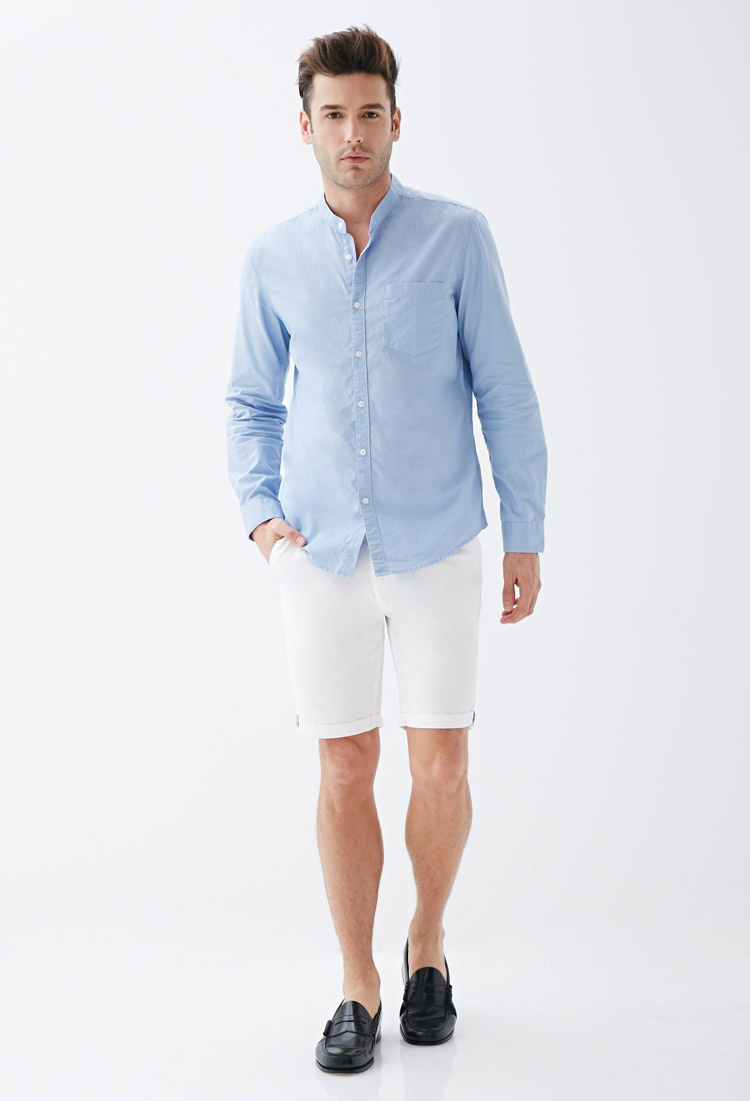

生成文本: The person is wearing a long-sleeve sweater with solid color patterns. The sweater is with cotton fabric. It has a round neckline. The person wears a long pants. The pants are with denim fabric and solid color patterns. The outer clothing is with cotton fabric and solid color patterns. This person is wearing a ring on her finger.


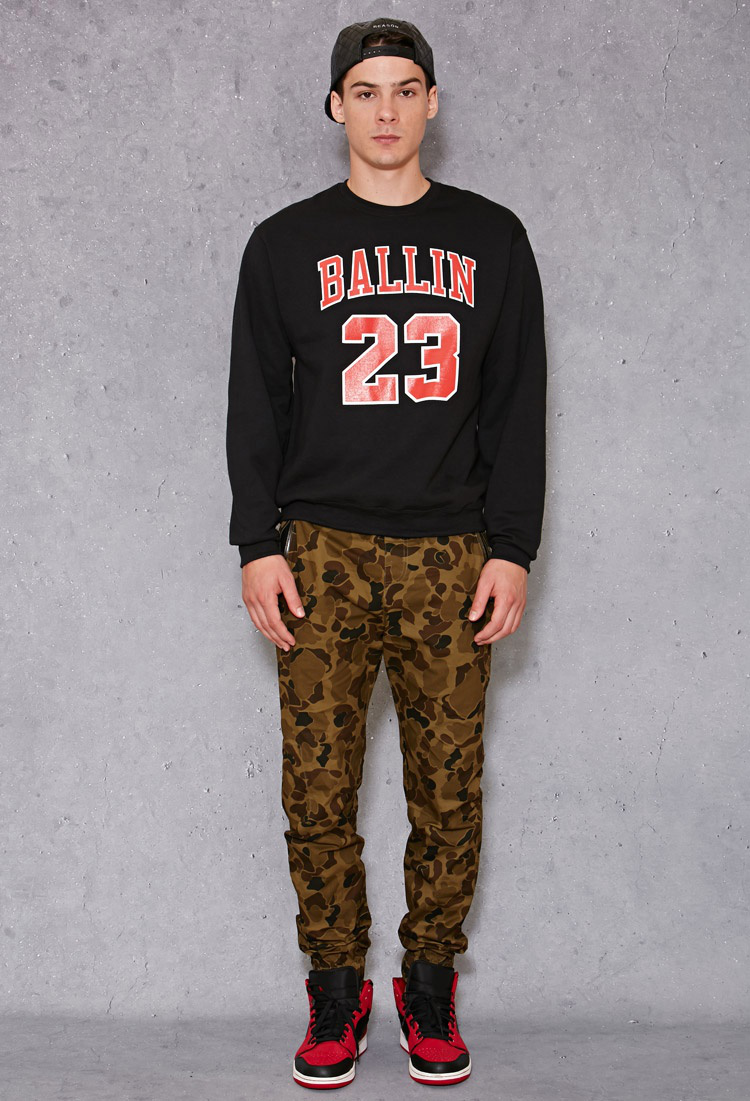

生成文本: The person is wearing a tank tank top with solid color patterns. The tank top is with cotton fabric. It has a suspenders neckline. The shorts the person wears is of three-point length. The shorts are with cotton fabric and solid color patterns. There is an accessory on her wrist. This woman wears a ring.


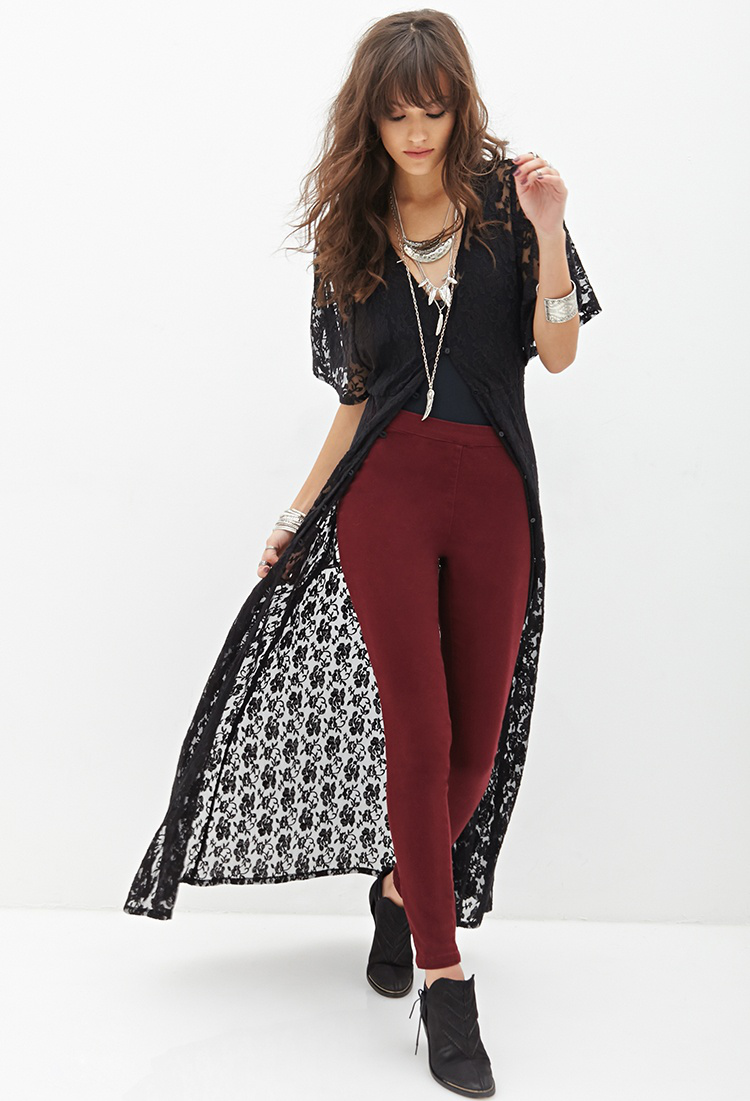

生成文本: The person is wearing a tank tank top with solid color patterns. The tank top is with cotton fabric. It has a suspenders neckline. The pants the person wears is of long length. The pants are with cotton fabric and solid color patterns. There is an accessory on her wrist. This person is wearing a ring on her finger.


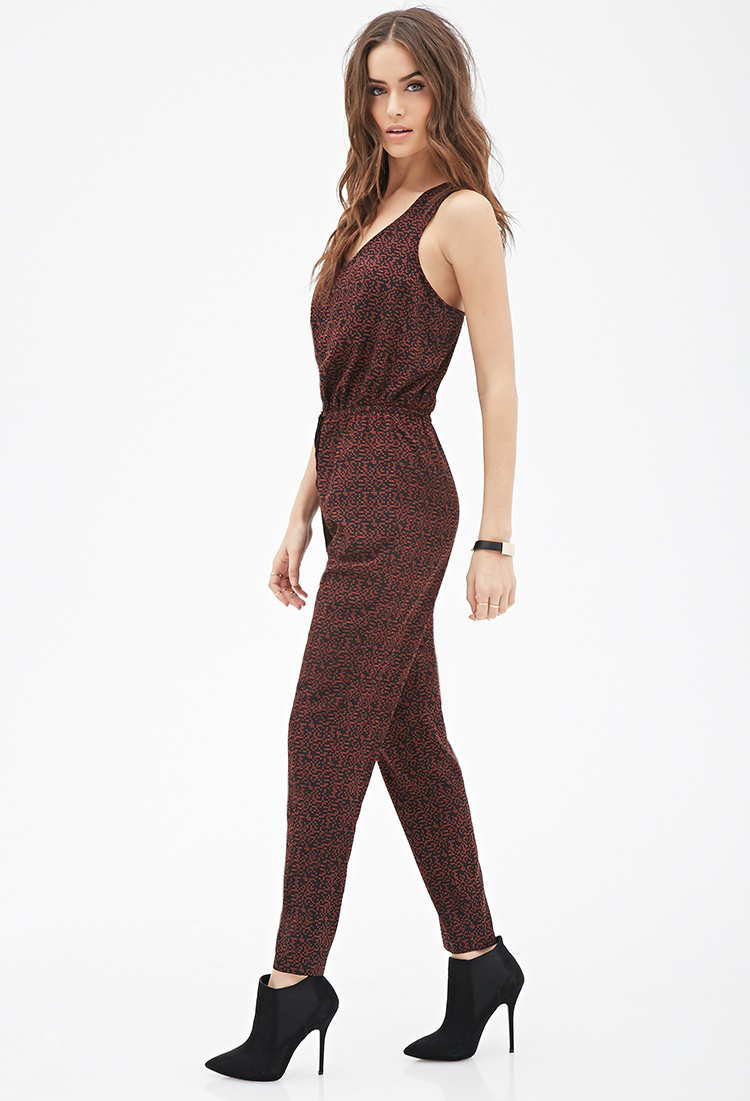

生成文本: The person is wearing a tank tank top with pure color patterns. The tank top is with cotton fabric. It has a suspenders neckline. The shorts the person wears is of long length. The shorts are with cotton fabric and solid color patterns. This person is wearing a ring on her finger.


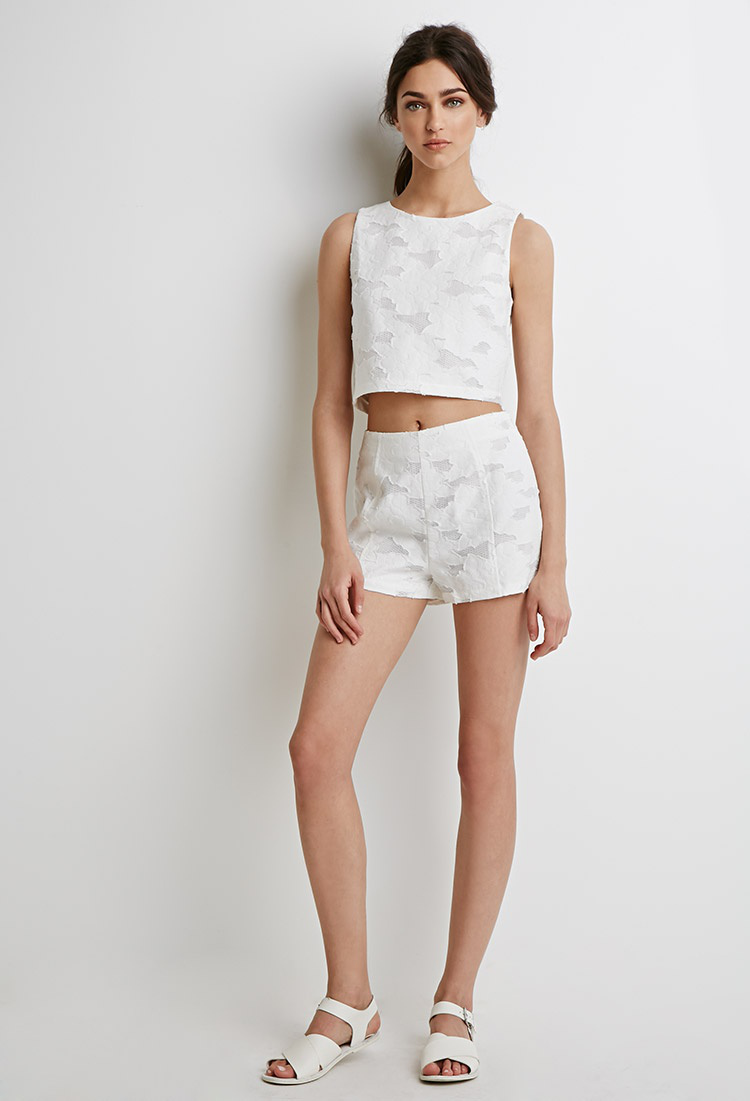

In [23]:
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from IPython.display import display
import numpy as np
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

def filter_cut_useless_words(sent, filterd_words):
    res=[]
    for w in sent:
        if w not in filterd_words:
            res.append(w)
        else:
            if w==155:
                return res
    return res
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
#image_folder = '/home/u2021213687/ImageCaptioning/to_show'
#image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
dataset = ImageFolder(root='/home/u2021213687/ImageCaptioning/to_show', transform=transform)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)
test_dataset = ImageTextDataset(test_json_path, vocab_path, split='test', transform=transform)
generated_captions = []
actual_captions = []
cands = []
refs = []

def idx_to_word(idx, vocab):#将向量转化为文本描述
    reverse_vocab = {v: k for k, v in vocab.items()}
    return reverse_vocab.get(int(idx), '<unk>')
filterd_words = set({test_dataset.vocab['<start>'], test_dataset.vocab['<end>'], test_dataset.vocab['<pad>']})
with torch.no_grad():
    for images, captions in dataloader:
        images = images.to(device)
        input_ids = images
        outputs,_ = model.generate_text(input_ids, max_length=95, start_token_id=test_dataset.vocab['<start>'])
        for i in range(outputs.shape[0]):
            gen_caption = [idx_to_word(idx, test_dataset.vocab) for idx in outputs[i]]
            if '<start>' in gen_caption:
                gen_caption = gen_caption[1:]  # 移除第一个元素 (<start>)
            if '<end>' in gen_caption:
                gen_caption = gen_caption[:gen_caption.index('<end>')]  # 移除 <end> 及其后面的元素
            
            sentence = ' '.join(gen_caption)
            print('生成文本:',sentence)
            img_path = os.path.join('/home/u2021213687/ImageCaptioning/to_show', dataset.imgs[i][0])
            img = Image.open(img_path)
            display(img)
          
        texts=outputs
        cands.extend([filter_cut_useless_words(text, filterd_words) for text in texts.tolist()])
         
        
        
    
